# Cover Type  Classification
##### This project is the final portfolio project for the Codecademy course called "Build Deep Learning Models with TensorFlow". The goal with this project is to perform basic data exploration and then build a deep learning model that can be used for cover type classification or forests. This will be done based on a given dataset that contains different cartographic varaibles.

## Data Exploration
All data exploration is done it the file called "Data-Exploration.ipynb", located in the same folder as this file. There tests are made to ensure the quality of the data and to ensure that the data is not corrupted. It also sumamrizes how the data has to be changed before usage.

## The Model

### Setting Up The File
This first step includes importing required libraries and preparing settings. The settings will later be sued for tuning the model.

In [42]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.layers import InputLayer, Dense
import math
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Settings
RANDOM_STATE = 42
TEST_SIZE = 0.2
BATCH_SIZE = 1024
EPOCHS = 10
CLASS_AMOUNT = 8
MIN_DELTA = 0.0001
PATIENCE = 3

### Clean Up Data
It is here that we'll modify the data set in the way we deamed necessary in the data exploration process.

In [11]:
def clean_data_set(data_set):
	return data_set[data_set['Vertical_Distance_To_Hydrology'] >= 0]

## Preparing Data Set
This function is used for preparing the data set. Splitting it up into features and labels, and standardizing the data.

In [12]:
def prep_data_set(data_set):

	# Split up data into features and labels
	features, labels = data_set.iloc[:, :-1], data_set.iloc[:, -1:];

	# One-hot encode
	features = pd.get_dummies(features)

	# Split data into train and test sets
	X_train, X_test, Y_train, Y_test = train_test_split(
		features,
		labels,
		test_size = TEST_SIZE,
		random_state = RANDOM_STATE,
		stratify = labels)

    # Normalize data
	scaler = StandardScaler()
	X_train = scaler.fit_transform(X_train)
	X_test = scaler.transform(X_test)

	return X_train, X_test, Y_train, Y_test

### Build Model
The build_mode() functio takes in the number of features the data has and uses this to create Keros Dense Layers with the decired amount of neurons. It outpus a Keras Model Object.

In [20]:
def build_model(num_features):
	classifier_model = keras.Sequential()

	classifier_model.add(InputLayer(input_shape = (num_features,)))
	# Add more layers here
	classifier_model.add(Dense(math.ceil(num_features*2/3), activation ='relu'))
	classifier_model.add(Dense(math.ceil(num_features*4/9), activation ='relu'))
	classifier_model.add(Dense(CLASS_AMOUNT, activation = 'softmax'))

	classifier_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

	return classifier_model

## Plotting History
Method based on given solution for ploting how the model performs in terms of accuracy and loss over several epochs.

In [23]:
def plot_history(history, param):
    if param == 'acc':
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
    elif param == 'loss':
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper right')
        plt.show()

### Plot Heatmap
This function is based on the given solution. It's used for plotting a heatmat and saving it to a file. Ths heatmap holds the resolut from a validation, compared to known solution.

In [46]:
def plot_heatmap(class_names, y_pred, y_test):

    cm = confusion_matrix(y_test, y_pred)

    fig, ax = plt.subplots(figsize=(15, 15))

    heatmap = sns.heatmap(cm, fmt='g', cmap='Blues', annot=True, ax=ax)

    ax.set_xlabel('Predicted class')
    ax.set_ylabel('True class')

    ax.set_title('Confusion Matrix')

    ax.xaxis.set_ticklabels(class_names)
    ax.yaxis.set_ticklabels(class_names)

    # Save the heatmap to file
    heatmapfig = heatmap.get_figure()
    heatmapfig.savefig(f'confusion_matrix.png')

### Main Method
The main method is from where we call our functions. Here we will create, train and test the model.

In [40]:
def main():

	# Load data
	print('Reading data...')
	data_set = pd.read_csv('cover_data.csv')

	# Clean data
	print('Cleaning data...')
	cleaned_data_set = clean_data_set(data_set)

    # Prepare data and split it up
	print('Preparing data...')
	X_train, X_test, Y_train, Y_test = prep_data_set(cleaned_data_set)

    # Build model
	print('Building model...')
	num_features = len(cleaned_data_set.columns) - 1 # -1 because we know from the data exploration that we are going to use 54 out of 55 columns as features
	classifier_model = build_model(num_features)

	# Summary of the model
	print('Summary report of the keras classifier model:')
	classifier_model.summary()

	# Train the classification model

	# Enable early stopping to prevent overfitting
	earlystop_callback = EarlyStopping(
		monitor = 'val_accuracy',
		min_delta = MIN_DELTA,
		patience = PATIENCE)
	
	# Save training data
	history = classifier_model.fit(
		X_train, 
		Y_train,
		batch_size = BATCH_SIZE,
		epochs = EPOCHS,
		validation_split = 0.1,
		verbose = 1,
		callbacks = [earlystop_callback])
	
	# Plot history (based on given solution)
	plot_history(history, 'acc')
	plot_history(history, 'loss')

	# Evaluate model
	loss, accuracy = classifier_model.evaluate(X_test, Y_test, verbose = 0)
	print('Test loss:', loss)
	print('Test accuracy:', accuracy)

	# Try predicting data
	print('Predict outcomes and compare to known outcomes...')
	Y_pred = classifier_model.predict(X_test)

	# Convert predicted values to discrete values
	Y_pred = np.argmax(Y_pred, axis = 1)
	class_names = ['Spruce/Fir', 'Lodgepole Pine',
                   'Ponderosa Pine', 'Cottonwood/Willow',
                   'Aspen', 'Douglas-fir', 'Krummholz']
	print(classification_report(Y_test, Y_pred, target_names = class_names))
	plot_heatmap(class_names, Y_pred, Y_test)

### Running The Code
Finally, we need the code to run. For that, we use the following code:

Reading data...
Cleaning data...
Preparing data...
Building model...
Summary report of the keras classifier model:
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 36)                1980      
                                                                 
 dense_34 (Dense)            (None, 24)                888       
                                                                 
 dense_35 (Dense)            (None, 8)                 200       
                                                                 
Total params: 3,068
Trainable params: 3,068
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
370/370 [==============================] - 2s 4ms/step - loss: 0.8672 - accuracy: 0.6638 - val_loss: 0.6496 - val_accuracy: 0.7345
Epoch 2/10
370/370 [==============================] - 1s 3

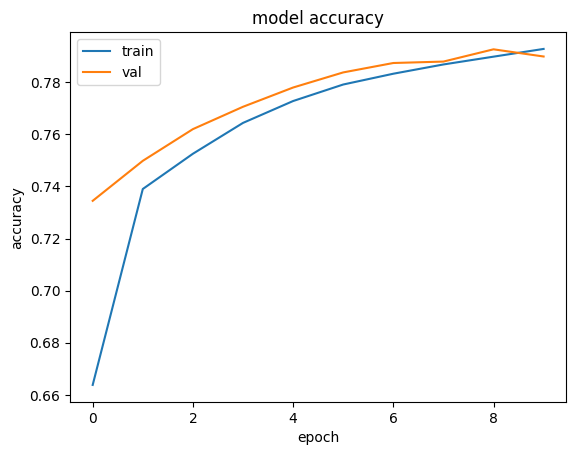

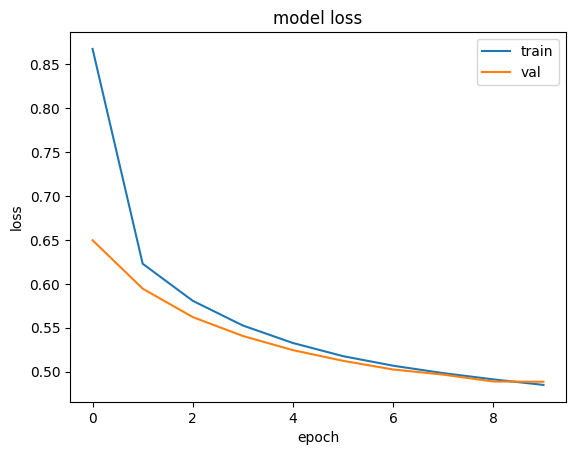

Test loss: 0.4870021343231201
Test accuracy: 0.7890353202819824
3287/3287 [==============================] - 4s 1ms/step
                   precision    recall  f1-score   support

       Spruce/Fir       0.75      0.83      0.79     37863
   Lodgepole Pine       0.84      0.80      0.82     51361
   Ponderosa Pine       0.73      0.87      0.79      6702
Cottonwood/Willow       0.78      0.51      0.62       537
            Aspen       0.70      0.25      0.37      1735
      Douglas-fir       0.61      0.43      0.50      3260
        Krummholz       0.84      0.74      0.78      3716

         accuracy                           0.79    105174
        macro avg       0.75      0.63      0.67    105174
     weighted avg       0.79      0.79      0.79    105174



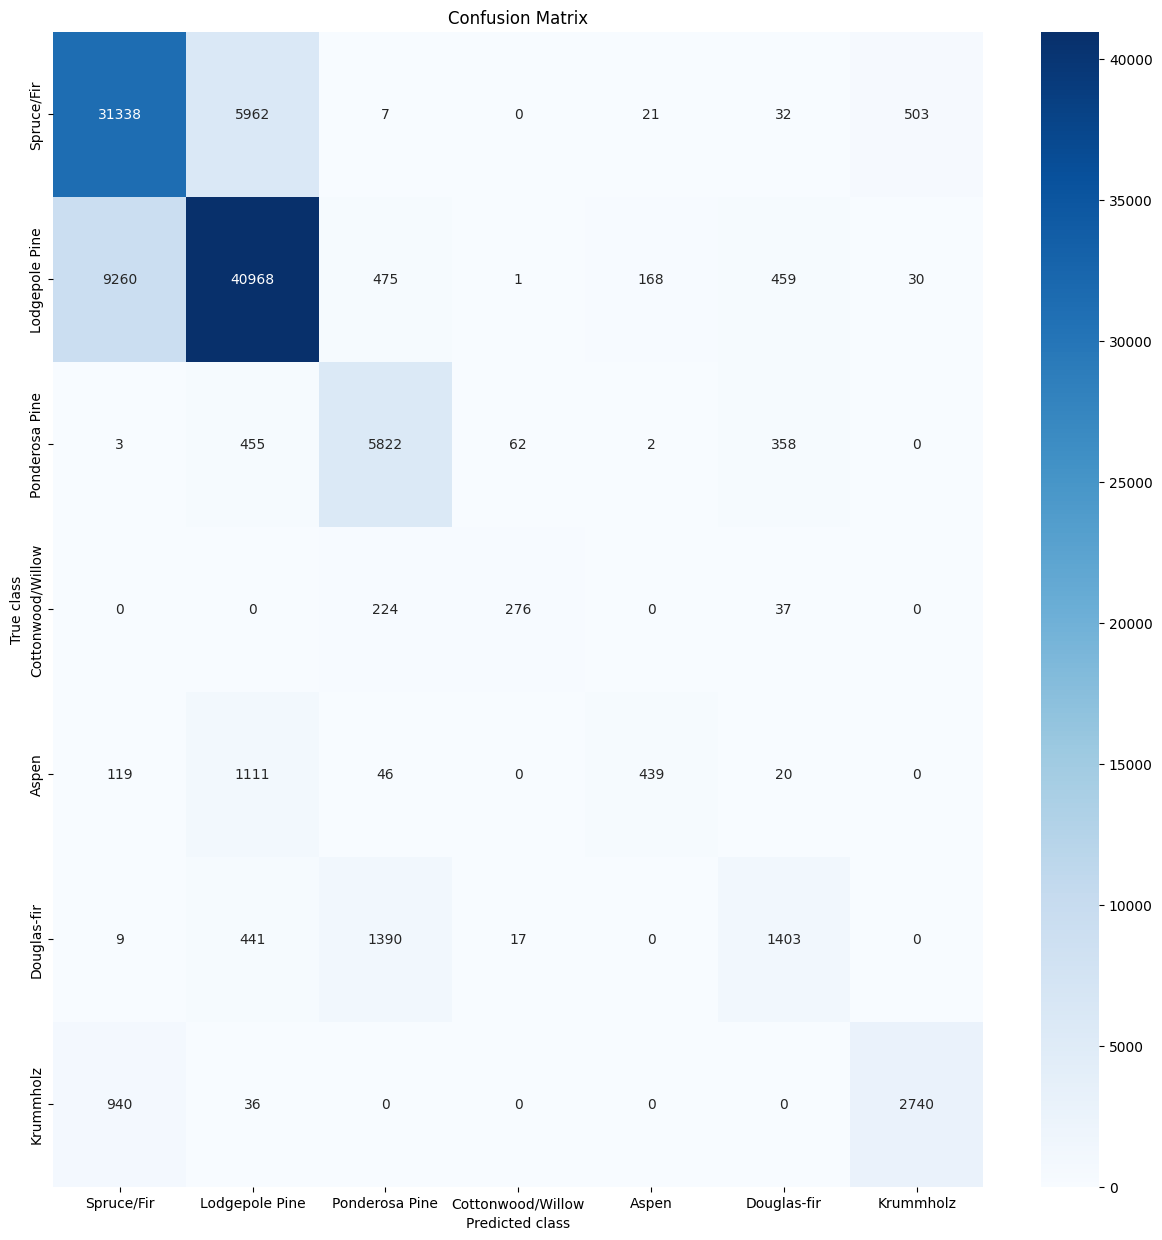

In [47]:
if __name__ == '__main__':
    main()

## Concolusion
Numbers along the diagonal of the heatmap showes the correct preictions. The horizontal axis shows the prediction, and the verical, the corect answer. From this heatmap we can easily see where the model performs well, and where it is not. For instance, we can see that Lodgepole Pine, Cottonwood Willow, Aspen, and Douglas-Fir has a high percentage of mis-classifications. How could we fix this?

1. Tune the model more.
2. Check for imbalance in the data set and fix this. Note that we could see the imblande during the data exploration.
3. Check for features these classes has in common, and remove them.
4. Clean the data more and remove any unclear records (remove noise).
5. Try different performance metrics than "accuracy" since it failes when the data is imbalanced. For instance, Precision/Recall, F1-score, and MCC.